## PII Anonymisation with LangGraph and Presidio

This notebook is a first draft for building a PII Anonymisation solution with LangGraph, Presidio and, in a later version, an LLM. The goal is to build an agentic system that processes uploaded documents, identifies Personally identifiable information (PII), redacts the PII and finally saves the new document with redacted PII.

The following tools are considered:
- LangGraph is an orchestration framework for complex agentic systems. It is more low-level and controllable than many other frameworks.
- Presidio is  a library that provides fast identification and anonymization modules for private entities in text and images such as credit card numbers, names, locations, social security numbers, bitcoin wallets, US phone numbers, financial data and more. It is different from other SaaS tools such as Azure AI Language and Amazon Comprehend which have less customization capabilities. Most of these SaaS offerings use dedicated ML models and other logic for PII detection and often have better entity coverage or accuracy than Presidio. Presidio can be leveraged in parallel to other PII detection services.
- LLM - In a future version an open-source LLM will be integrated in the agentic system. Possible LLMs include LLama 3, Mistral, or SaulLM-7B which is an open-source LLM tailored for the legal domain.

Draft of the agentic system:
- Get input - for simplicity I am only using a prompt with text at the moment
- Pre-process input - current version involves only a function to verify the text is in English
- Subgraph for identifying and redacting PII - at the moment only implemented with Presidio
- Return output with blank PII

In [1]:
# Install necessary packages
%pip install --upgrade --quiet  langgraph langchain poetry langchain-experimental presidio-analyzer presidio-anonymizer langchain-ollama

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import statements
import os

from IPython.display import Image, display
from typing import TypedDict

from langgraph.graph import StateGraph, START, END

from langdetect import detect

from presidio_analyzer import AnalyzerEngine
from presidio_anonymizer import AnonymizerEngine

from utils import get_langsmith_key


In [3]:
# Using LangSmith is recommended but not required
os.environ["LANGSMITH_TRACING"] = "true"
langsmith_key = get_langsmith_key()
os.environ["LANGSMITH_API_KEY"] = langsmith_key

# Required only if using the EU instance
LANGSMITH_ENDPOINT = "https://api.langsmith.com"

Since we want to prevent the inputs and outputs of our traces from being logged, we can hide them by setting the following environment variables. This works for both the LangSmith SDK (Python and TypeScript) and LangChain.

In [4]:
# Hide inputs and outputs 
LANGSMITH_HIDE_INPUTS = True
LANGSMITH_HIDE_OUTPUTS = True

In [5]:
# Create a class to hold the original text in the ParentState
class ParentState(TypedDict):
    text:str

In [6]:
# Create a class to hold the request and response for the anonymizer
class SubgraphState(TypedDict):
    text:str
    anonymized_text:str

In [7]:
# Node function to get the text from the ParentState
def get_text(state:ParentState):
    """
    This function gets the text from the ParentState and returns it.
    """
    return {"text": state["text"]}

In [8]:
# Node function to check if the input is in English
def is_text_in_english(state: ParentState) -> dict:
    """
    This function checks if the text in the ParentState is in English.
    It uses langdetect to detect the language of the text.
    If the language is English, it returns the next node to call the anonymize_text_subgraph.
    """
    text = state.get("text", "")

    # Using langdetect to detect language and check if text is in English
    try:
        detected_language = detect(text)
        if detected_language == 'en':  # If the language is English
            return {"next_node": "call_anonymize_text_subgraph"}  # Correct node name for the next step
        else:
            print("Text is not in English. This pipeline only supports English text.")
            return {"next_node": END}  # If not English, return END
    except Exception as e:
        print(f"Error detecting language: {e}")
        return {"next_node": END}  # Return "END" in case of error


In [9]:
# Node function to anonymizes the text using the Presidio Analyzer and Anonymizer engines
def anonymize_text(state:SubgraphState):
    """
    This function anonymizes the text using the Presidio Analyzer and Anonymizer engines.
    It takes in the original text, analyzes it, and then anonymizes it.
    It returns the original text and the anonymized text.
    """
    analyzer = AnalyzerEngine()
    anonymizer = AnonymizerEngine()
    original_text = state["text"]
    result = analyzer.analyze(text=original_text, language="en")
    state["anonymized_text"] =anonymizer.anonymize(text=original_text,analyzer_results=result).text
    return {"text":original_text +" anonymized_text="+state["anonymized_text"]}

Sub-graphs allow us to create and manage different states in different parts of the graph. This is particularly useful for multi-agent systems, with teams of agents that each have their own state. The most critical thing to understand is how the graphs communicate. In short, communication is done with over-lapping keys.

In [10]:
# Build the subgraph
subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node("anonymize_text_node", anonymize_text)
subgraph_builder.add_edge(START,"anonymize_text_node")

# Compile the subgraph
subgraph = subgraph_builder.compile()

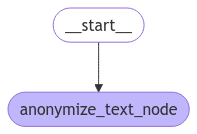

In [11]:
# View the subgraph
display(Image(subgraph.get_graph().draw_mermaid_png()))

In [12]:
# Build the parent graph
parent_graph_builder = StateGraph(ParentState)
parent_graph_builder.add_node("get_input", get_text)
parent_graph_builder.add_node("preprocessing", is_text_in_english)
parent_graph_builder.add_node("call_anonymize_text_subgraph", subgraph)

# Ensure nodes are connected in the correct sequence
parent_graph_builder.add_edge(START, "get_input")
parent_graph_builder.add_edge("get_input", "preprocessing")

# Conditional edge uses a dictionary to handle routing
parent_graph_builder.add_conditional_edges(
    "preprocessing",  # Source node
    lambda state: state.get("next_node", "END")  # Routing based on the 'next_node' key
)

# Finally, connect to END node
parent_graph_builder.add_edge("call_anonymize_text_subgraph", END)

# Compile the parent graph
graph = parent_graph_builder.compile()

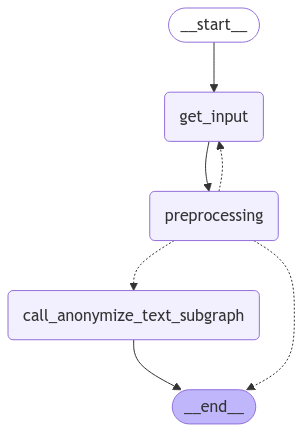

In [13]:
# View the parent graph
display(Image(graph.get_graph().draw_mermaid_png()))

When we invoke the graph with the below input it correctly identifies all the PII although there is an error that the bank account number is identified as <DATE_TIME>.

In [14]:
# Invoke the graph with text in English
result = graph.invoke({"text": "My bank account is 808123456789012 and my email is jane@example.com, and phone number 123-456-7890. Best, Jane Doe Phone: (123) 456-7890 Email: jane@example.com"})
print(result)

{'text': 'My bank account is 808123456789012 and my email is jane@example.com, and phone number 123-456-7890. Best, Jane Doe Phone: (123) 456-7890 Email: jane@example.com anonymized_text=My bank account is <DATE_TIME> and my email is <EMAIL_ADDRESS>, and phone number <PHONE_NUMBER>. Best, <PERSON> Phone: <PHONE_NUMBER> Email: <EMAIL_ADDRESS>'}


When we invoke the graph with the below input containing a rare name it doesn't identify the name as PII but it identifies the phone number.

In [15]:
# Invoke the graph with text in English
result = graph.invoke({"text": "My name is Tsvetina and I am my phone number is 080-456-7890."})
print(result)

{'text': 'My name is Tsvetina and I am my phone number is 080-456-7890. anonymized_text=My name is Tsvetina and I am my phone number is <PHONE_NUMBER>.'}


When we invoke the graph with non-English input, the error is correctly identified.

In [16]:
# Invoke the graph with text in Spanish
result = graph.invoke({"text": "Hola mi nombre es Jane, Como estas? jane@example.com"}) 
print(result)

Text is not in English. This pipeline only supports English text.
{'text': 'Hola mi nombre es Jane, Como estas? jane@example.com'}
